In [18]:
import numpy as np
data=np.load('/home/share/TmpData/Qinglin/ABIDE/X.npy')

In [16]:
del vae

NameError: name 'vae' is not defined

In [19]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 20
original_dim=data.shape[1]
latent_dim = 32

epochs = 200
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(256, activation='tanh')(x)
h = Dense(128, activation='tanh')(h)
h = Dense(64, activation='tanh')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later

h_decoded = Dense(64, activation='tanh')(z)
h_decoded = Dense(128, activation='tanh')(h_decoded)
h_decoded = Dense(256, activation='tanh')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='tanh')(h_decoded)

# instantiate VAE model
#vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

#vae.add_loss(vae_loss)
from keras import optimizers
rmsprop=optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)
#vae.compile(optimizer=rmsprop)
#vae.summary()




encoder = Model(x, z_mean)



In [20]:
from keras.models import load_model



# returns a compiled model
# identical to the previous one
vae = load_model('/home/share/TmpData/Qinglin/ABIDE/vae.h5')


NameError: name 'latent_dim' is not defined

In [21]:
latent_dim

32

In [58]:
decoder=Model(x, z)
y=decoder.predict(data,
        batch_size=batch_size)
y.shape

(1950, 32)

ValueError: x and y must have same first dimension, but have shapes (200,) and (1950,)

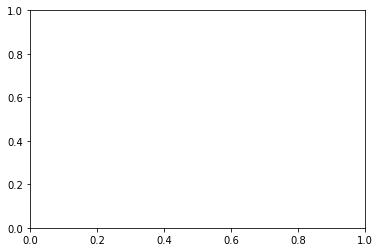

In [59]:

import numpy as np
t = range(0, 200)

import matplotlib.pyplot as plt
plt.plot(t, y[:,1])

In [60]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(y,data)
np.transpose(clf.coef_)

array([[-0.        ,  0.        ,  0.        , ..., -0.        ,
         0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02965349,
        -0.        ,  0.        ],
       ...,
       [-0.        , -0.05716886, -0.04323278, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       [-0.        , -0.01372148, -0.        , ..., -0.00746739,
        -0.        , -0.        ]], dtype=float32)

In [61]:
components=np.transpose(clf.coef_)

In [62]:
from scipy import stats
#components=stats.zscore(components,axis=1)

import numpy as np
from scipy.stats import scoreatpercentile

abs_components = np.abs(components)
ratio=100. - (100. / len(components)) *3
threshold = scoreatpercentile(abs_components,ratio)
components[abs_components < threshold] = 0

for component in components:

    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1
        
import numpy as np
components_img = masker.inverse_transform(components)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


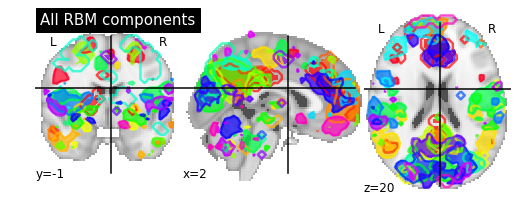

In [63]:
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='All RBM components')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


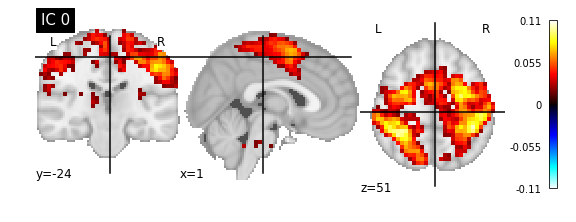

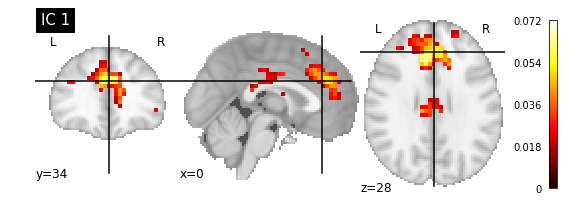

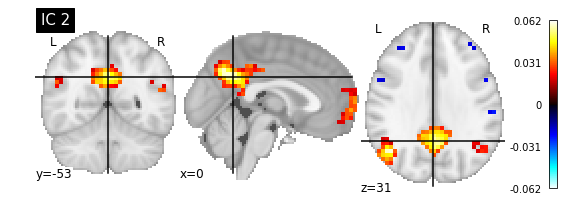

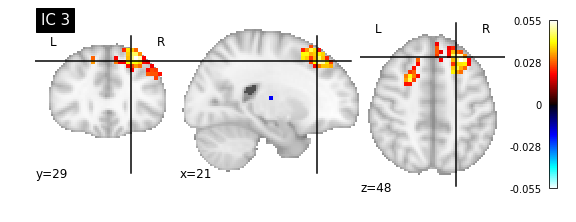

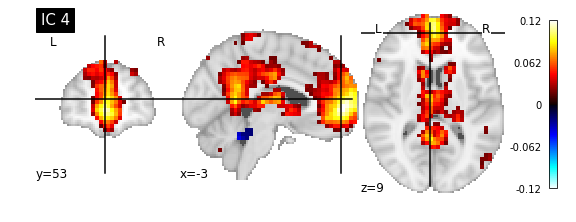

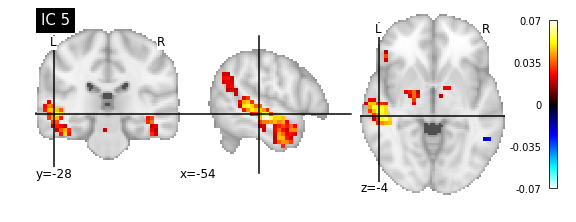

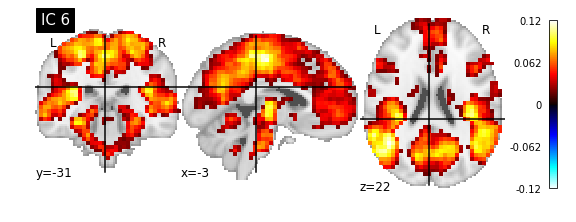

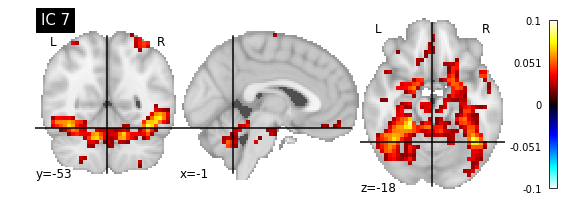

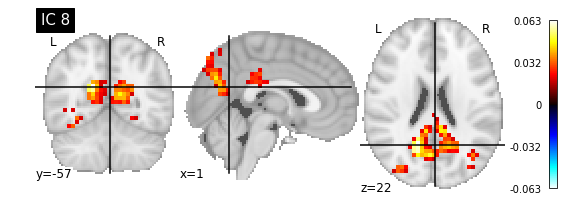

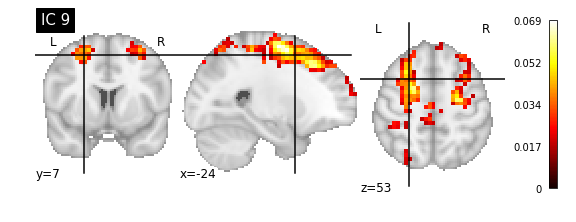

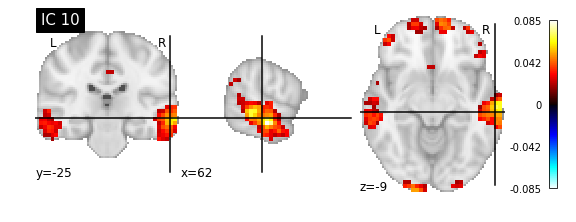

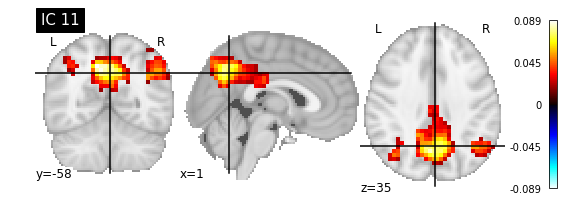

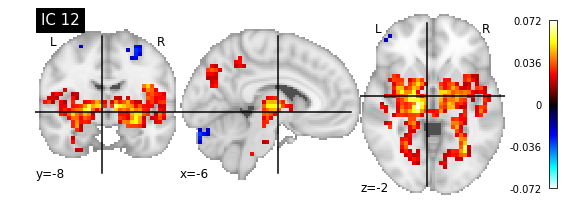

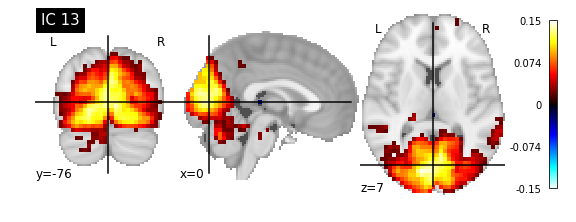

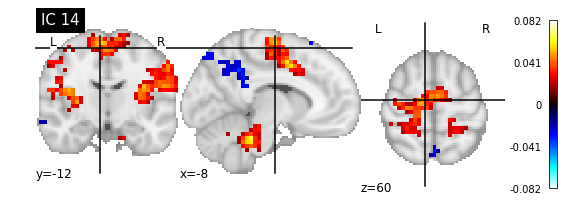

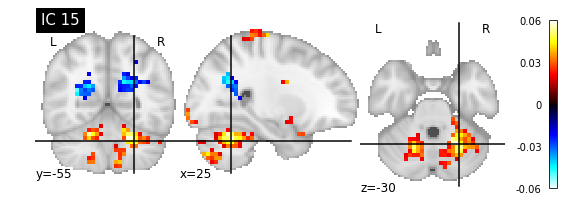

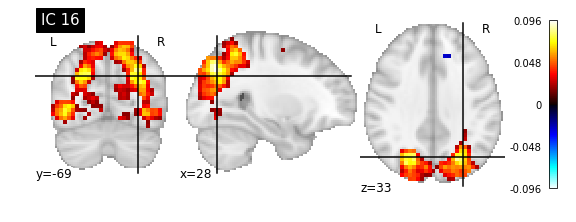

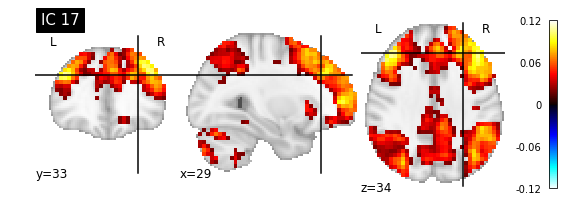

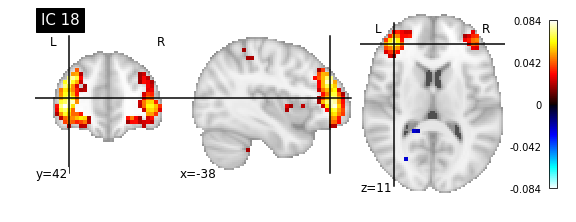

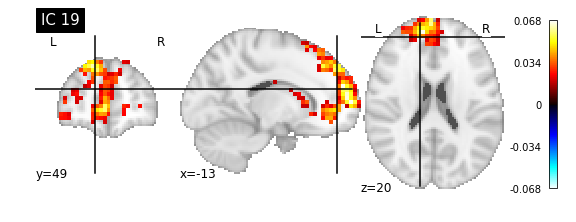

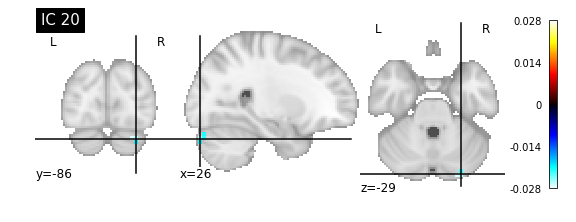

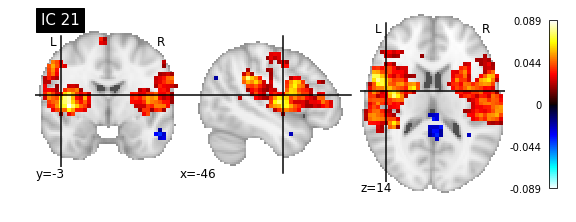

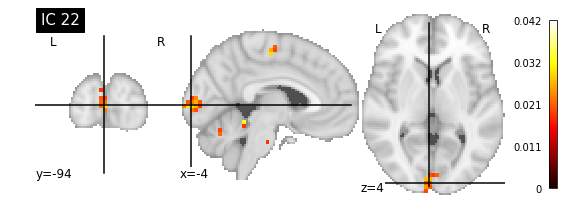

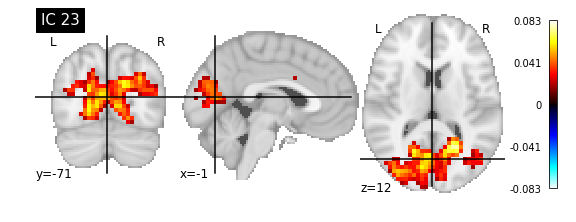

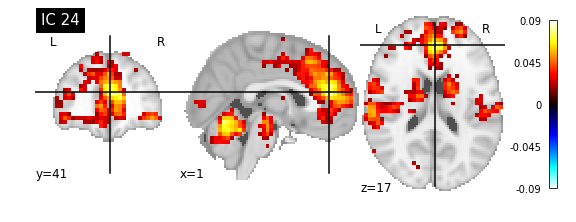

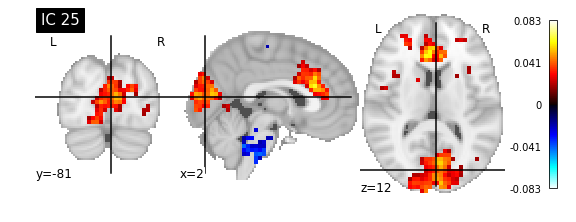

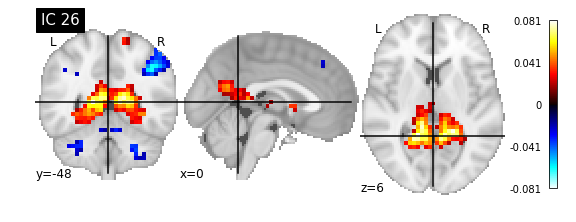

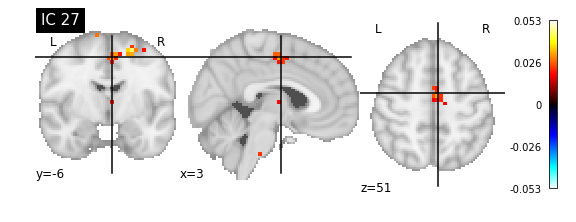

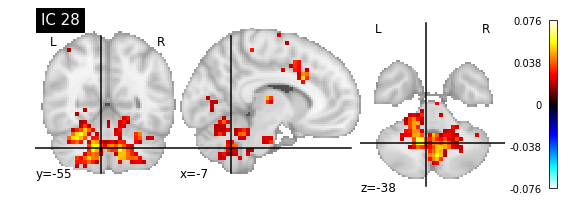

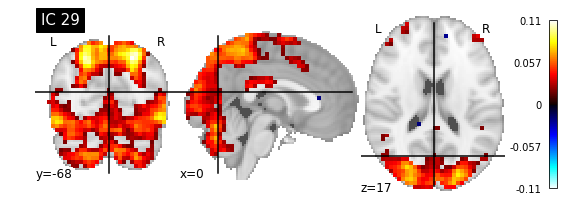

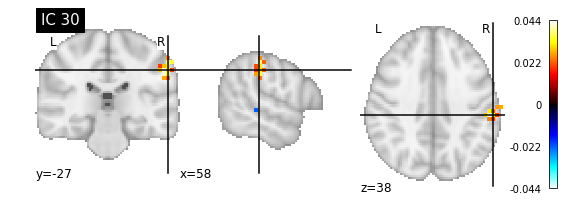

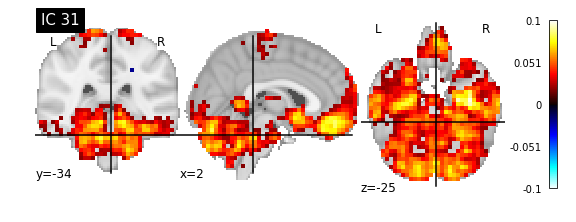

In [64]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()